# Neural Network Model

In [87]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [88]:
#from layer import Layer
import numpy as np

# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of edges that connects to neurons in next layer
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [89]:
#from layer import Layer

# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [90]:
import numpy as np;

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return max(x)

def relu_prime(x):
    return np.where(x > 0, 1.0, 0.0)

def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

In [91]:

import numpy as np

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [92]:
# example of a function for calculating softmax for a list of numbers
from numpy import exp
 
# calculate the softmax of a vector
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

In [93]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

        
    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network 
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        '''
        Fit function does the training. 
        Training data is passed 1-by-1 through the network layers during forward propagation.
        Loss (error) is calculated for each input and back propagation is performed via partial 
        derivatives on each layer.
        '''
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

# Predict the humidity level at 3 pm with given mintemp and maxtemp [Albury]

---



In [94]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Hours per week and earning more than 50K
url = 'https://raw.githubusercontent.com/OrcunSelbasan/neural-network/main/weatherAUS.csv';
data = pd.read_csv(url)
data_albury = data[data["Location"] == "Albury"]

# MinTemp Norm
raw_input_min = np.array(data_albury["MinTemp"])
min_raw = min(raw_input_min)
max_raw = max(raw_input_min)
raw_input_min = [x for x in raw_input_min if str(x) != 'nan']
raw_input_min = [(element - min_raw) / (max_raw - min_raw) for element in raw_input_min][:200]

# MaxTemp Norm
raw_input_max = np.array(data_albury["MaxTemp"])
min_raw = min(raw_input_max)
max_raw = max(raw_input_max)
raw_input_max = [x for x in raw_input_max if str(x) != 'nan']
raw_input_max = [(element - min_raw) / (max_raw - min_raw) for element in raw_input_max][:200]

# Merge MinTemp and MaxTemp
nest_input_data = [[raw_input_min[i], raw_input_max[i]] for i in range(len(raw_input_min))]
nest_input_data = [[element] for element in nest_input_data][:200]


# Humidity Norm
raw_output_data = np.array(data_albury["Humidity3pm"])
min_raw = min(raw_output_data)
max_raw = max(raw_output_data)
raw_output_data = [x for x in raw_output_data if str(x) != 'nan']
raw_output_data = [(e - min_raw) / (max_raw - min_raw) for e in raw_output_data][:200]

nest_output_data = [[(element - min_raw) / (min_raw - max_raw)] for element in raw_output_data]
nest_output_data = [[element] for element in nest_output_data][:200]

# training data
x_train = np.array(nest_input_data)  
y_train = np.array(nest_output_data)   

# x_train = np.array([[[0,0]], [[1,0]], [[0,1]], [[1,1]]]) 
# y_train = np.array([[[0]], [[0]], [[0]], [[1]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train[:160], y_train[:160], epochs=1000, learning_rate=0.5)

# test
out = net.predict(x_train[160:200])
print(nest_output_data[160:200])
print(out)

epoch 1/1000   error=0.002277
epoch 2/1000   error=0.000029
epoch 3/1000   error=0.000029
epoch 4/1000   error=0.000028
epoch 5/1000   error=0.000028
epoch 6/1000   error=0.000027
epoch 7/1000   error=0.000026
epoch 8/1000   error=0.000026
epoch 9/1000   error=0.000025
epoch 10/1000   error=0.000025
epoch 11/1000   error=0.000024
epoch 12/1000   error=0.000024
epoch 13/1000   error=0.000024
epoch 14/1000   error=0.000023
epoch 15/1000   error=0.000023
epoch 16/1000   error=0.000022
epoch 17/1000   error=0.000022
epoch 18/1000   error=0.000022
epoch 19/1000   error=0.000022
epoch 20/1000   error=0.000021
epoch 21/1000   error=0.000021
epoch 22/1000   error=0.000021
epoch 23/1000   error=0.000020
epoch 24/1000   error=0.000020
epoch 25/1000   error=0.000020
epoch 26/1000   error=0.000020
epoch 27/1000   error=0.000019
epoch 28/1000   error=0.000019
epoch 29/1000   error=0.000019
epoch 30/1000   error=0.000019
epoch 31/1000   error=0.000019
epoch 32/1000   error=0.000018
epoch 33/1000   e

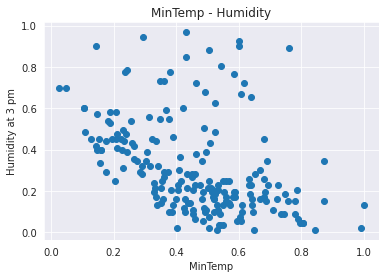

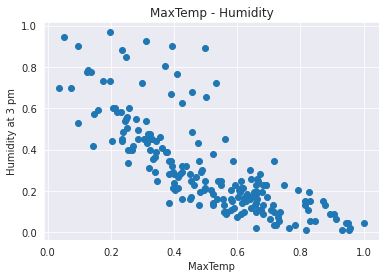

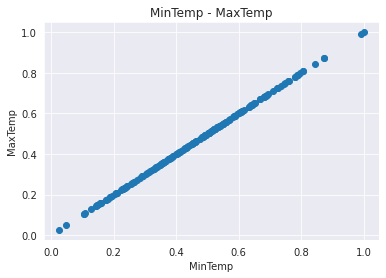

In [95]:
plt.scatter(raw_input_min, raw_output_data)
plt.title("MinTemp - Humidity")
plt.xlabel("MinTemp")
plt.ylabel("Humidity at 3 pm")
plt.show()

plt.scatter(raw_input_max, raw_output_data)
plt.title("MaxTemp - Humidity")
plt.xlabel("MaxTemp")
plt.ylabel("Humidity at 3 pm")
plt.show()


plt.scatter(raw_input_min, raw_input_min)
plt.title("MinTemp - MaxTemp")
plt.xlabel("MinTemp")
plt.ylabel("MaxTemp")
plt.show()

# Python Code for Evaluation Metrics in ML/AI for Classification Problems

https://analyticsindiamag.com/evaluation-metrics-in-ml-ai-for-classification-problems-wpython-code/

In [96]:
 from sklearn.datasets import load_breast_cancer
 from sklearn.ensemble import RandomForestClassifier
 from sklearn.model_selection import train_test_split
 from sklearn import metrics
 import pandas as pd
 import numpy as np
 from matplotlib import pyplot as plt
 import seaborn as sns
 sns.set_style('darkgrid') 

In [97]:
 # choose a binary classification problem
 data = load_breast_cancer()
 # develop predictors X and target y dataframes
 X = pd.DataFrame(data['data'], columns=data['feature_names'])
 y = abs(pd.Series(data['target'])-1)
 # split data into train and test set in 80:20 ratio
 X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)
 # build a RF model with default parameters
 model = RandomForestClassifier(random_state=1)
 model.fit(X_train, y_train)
 preds = model.predict(X_test) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


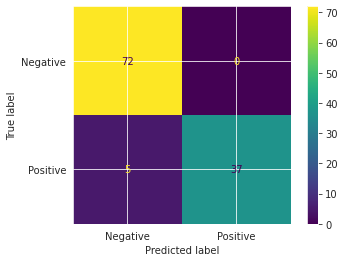

In [98]:
metrics.plot_confusion_matrix(model, X_test, y_test, display_labels=['Negative', 'Positive'])

In [99]:
 confusion = metrics.confusion_matrix(y_test, preds)
 confusion.ravel() 

array([72,  0,  5, 37])

# Evaluating Performance of Classification

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

F1-score = 2 * Precision * Recall / (Precision + Recall)

Accuracy = TP + TN / (TP + FP + TN + FN)

In [100]:
 accuracy = metrics.accuracy_score(y_test, preds)
accuracy

0.956140350877193

In [101]:
 precision_positive = metrics.precision_score(y_test, preds, pos_label=1)
 precision_negative = metrics.precision_score(y_test, preds, pos_label=0)
 precision_positive, precision_negative

(1.0, 0.935064935064935)

In [102]:
 recall_sensitivity = metrics.recall_score(y_test, preds, pos_label=1)
 recall_specificity = metrics.recall_score(y_test, preds, pos_label=0)
 recall_sensitivity, recall_specificity 

(0.8809523809523809, 1.0)

In [103]:
 f1_positive = metrics.f1_score(y_test, preds, pos_label=1)
 f1_negative = metrics.f1_score(y_test, preds, pos_label=0)
 f1_positive, f1_negative 

(0.9367088607594937, 0.9664429530201343)